# **The Predicted Interest Rate?, Welcome to the Lending Club**

# Project Description

The dataset contains the full LendingClub data available, including 150 columns and 128,334 rows. There is a separate file for rejected loans, which not included. The dataset is the accepted loans file, with the interest rates offered, including the FICO scores, annual income, funded amount, revolving balance, loan purposes, loan terms, and many others. 

# Task

The model is predicting interest rate which is a continuous random variable. Hence regression models are built using two types of algorithms namely Linear Regression and a Tree based regression model. The features are wrangled and transformed in order to drop unnecessary columns and address categorical variables.

Compare three models, Ridge, RandomForestRegressor, and XgbRegressor, and then finalize the best model with best hyper parameters plug-in. Use cross validation calculations on RandomForestRegressor, and XgbRegressor models to identify the best result of hyper parameters between the two, and then compare with the Ridge model to finalize the best model, for the target prediction, interest rate.

Identify the feature importance by various charts; visualize how features impact the interest rate offered.

# **1. Loading raw data**

In [ ]:
%%capture
import sys

# If on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    # Shapley and PDP, Partial Dependence Plot
    !pip install pdpbox
    !pip install shap
    # Profile Report
    #!pip install pandas-profiling==2.7.1 # Profile Report must use 2.7.1 ver to work

# If working locally:
else:
    DATA_PATH = '../data/'

In [ ]:

# data analysis and wrangling
import pandas as pd
import numpy as np

# dataframe Profile Report
#from pandas_profiling import ProfileReport

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Linear regression and ridge to generalize
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
# from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve
# from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning

from IPython.display import Image
from IPython.core.display import HTML 

# Shapley and PDP, Partial Dependence Plot
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

# If df size too large, use the following
pd.options.display.max_rows = 300
#pd.set_option("display.max_rows", None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2. Wrangle Dataset and EDA**

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath,parse_dates=['issue_d'],index_col='issue_d', skipinitialspace=True).sort_index()

  # Consider only data with 36 month term period(without 60 months term), as 102996 (36 months term) among 128334 observations 
  df = df[df['term']=='36 months']
  df.drop(columns='term',inplace=True)

  # Consildate values in the title column as features into categories
  keywords = ['green loan|business', 'freedom|payoff|debt|consolidation|credit', 'home', 'wedding|vacation|medical|moving', 'car|major purchase']
  for col in keywords:
    df[col] = df['title'].fillna('').str.lower().str.contains(col,regex=True).astype(int)
    
  # condition the outstanding revolving balance greater than $10,000 into category, as 50%+ of the borrowers with standing revolving balance of $10,000 or more
  df['revol_bal_$10,000+'] = (df['revol_bal'] >=10000).replace(True, 1).astype(int)

  # Columns retained for the model 
  cols_to_keep = keywords + ['int_rate', 'fico_range_high', 'funded_amnt', 'annual_inc', 'revol_bal_$10,000+']
  df = df[cols_to_keep]

  # Clean up the interest rate column
  df['int_rate'] = df['int_rate'].str.strip('%').astype(float)

  # Renaming certain columns for ease of use in the model building
  # green loan is for the business purpose
  # freedom, payoff, debt, consolidation, credit is for the debt consolidation purpose
  # wedding, vacation, medical, moving is for the personal purpose
  # car is for the major purchase purpose
  df.rename(columns={'green loan|business':'business','freedom|payoff|debt|consolidation|credit':'consolidation','wedding|vacation|medical|moving':'personal', 'car|major purchase':'major_purchase'},inplace=True)

  return df

# After dataset wrangling, review of dataset as the following with visualization in chart, in order to evaluate the dataset is fine to proceed with analysis.

In [ ]:
df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [ ]:
df.shape

(102996, 10)

In [ ]:
df.head()

,business,consolidation,home,personal,major_purchase,int_rate,fico_range_high,funded_amnt,annual_inc,"revol_bal_$10,000+"
issue_d,,,,,,,,,,
2007-07-01,0,0,0,0,0,10.28,684.0,3500.0,20000.0,0
2007-07-01,0,0,0,0,0,7.43,774.0,5000.0,95000.0,0
2007-07-01,0,0,0,0,0,7.43,779.0,5000.0,150000.0,0
2007-07-01,0,0,0,0,0,10.28,679.0,3000.0,200000.0,0
2007-08-01,0,0,0,0,0,7.75,749.0,4000.0,61800.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102996 entries, 2007-07-01 to 2019-03-01
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   business            102996 non-null  int64  
 1   consolidation       102996 non-null  int64  
 2   home                102996 non-null  int64  
 3   personal            102996 non-null  int64  
 4   major_purchase      102996 non-null  int64  
 5   int_rate            102996 non-null  float64
 6   fico_range_high     102996 non-null  float64
 7   funded_amnt         102996 non-null  float64
 8   annual_inc          102996 non-null  float64
 9   revol_bal_$10,000+  102996 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 8.6 MB


# Visualization of target variable, interest rate, in distribution in chart, and the curve is fine to proceed with further various model analysis after data wrangling.

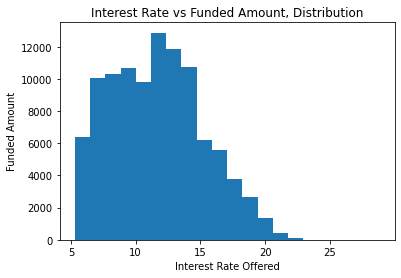

In [ ]:
# chart with target variable and labels, to evaluate distribution curve

import seaborn as sns

fig, ax = plt.subplots()

ax.hist(df['int_rate'], bins=20)

ax.set_xlabel('Interest Rate Offered') 
ax.set_ylabel('Funded Amount') 
ax.set_title('Interest Rate vs Funded Amount, Distribution') 

plt.show()


In [ ]:
# print(df['term'].value_counts())# 
# print(df['int_rate'].value_counts())#
# print(df['loan_status'].value_counts())
# print(df['revol_bal'].value_counts())#
# print(df['hardship_flag'].value_counts())
# print(df['hardship_type'].value_counts())#
# print(df['home_ownership'].value_counts())#
# print(df['annual_inc'].value_counts())#
# #print(df['title'].value_counts())#
# print(df['tax_liens'].value_counts())

In [ ]:
#print(df['title'].value_counts().head(50))#

In [ ]:
#print(df['revol_bal'].value_counts().head(50))# larger than 5000

In [ ]:
# print(df['term'].isnull().sum())
# print(df['int_rate'].isnull().sum())
# print(df['loan_status'].isnull().sum())
# print(df['revol_bal'].isnull().sum())
# print(df['hardship_flag'].isnull().sum())
# print(df['hardship_type'].isnull().sum())
# print(df['home_ownership'].isnull().sum())
# print(df['annual_inc'].isnull().sum())
# print(df['title'].isnull().sum()) #dropna
# print(df['tax_liens'].isnull().sum()) #dropna

In [ ]:
df.describe(include='all')

,business,consolidation,home,personal,major_purchase,int_rate,fico_range_high,funded_amnt,annual_inc,"revol_bal_$10,000+"
count,102996.000000,102996.000000,102996.000000,102996.000000,102996.000000,102996.000000,102996.000000,102996.000000,1.029960e+05,102996.000000
mean,0.010185,0.749068,0.065342,0.029817,0.253932,11.633462,701.374549,12600.954649,7.518329e+04,0.515059
std,0.100405,0.433552,0.247130,0.170082,0.435261,3.623209,32.747740,8192.746696,8.125865e+04,0.499776
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.310000,664.000000,500.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,8.390000,674.000000,6400.000000,4.500000e+04,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,11.490000,694.000000,10000.000000,6.300000e+04,1.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,13.990000,719.000000,16325.000000,9.000000e+04,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,28.800000,850.000000,40000.000000,9.300000e+06,1.000000


In [ ]:
# !pip3 install joblib
# !pip3 install dill
# import dill as pickle

# profile = ProfileReport(df)
# profile

# **3. Split Data**

In [ ]:
# Split into Feature Matrix and Target Valdiation
target = 'int_rate'
X,y = df.drop(columns=target),df[target]

In [ ]:
X.shape

(102996, 9)

In [ ]:
# Split into train, val and test data
X_train,y_train = X.head(70000),y[:70000]
X_val,y_val = X[70000:85000],y[70000:85000]
X_test,y_test = X[85000:102996],y[85000:102996]

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((70000, 9), (15000, 9), (17996, 9))

In [ ]:
#Create train-validation split to compare with train-val process
#X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# **4. Establish Baseline**

In [ ]:
y_pred_bl = [y_train.mean()]*len(y_train)
print('Mean interest rate',y_train.mean())
print('Baseline MAE',mean_absolute_error(y_train,y_pred_bl))

Mean interest rate 11.48878628571345
Baseline MAE 2.9048040458449176


# **5. Build Models for MAE, Mean Absolute Error, and R2 Score Comparisons**

In [ ]:
df.head()

,business,consolidation,home,personal,major_purchase,int_rate,fico_range_high,funded_amnt,annual_inc,"revol_bal_$10,000+"
issue_d,,,,,,,,,,
2007-07-01,0,0,0,0,0,10.28,684.0,3500.0,20000.0,0
2007-07-01,0,0,0,0,0,7.43,774.0,5000.0,95000.0,0
2007-07-01,0,0,0,0,0,7.43,779.0,5000.0,150000.0,0
2007-07-01,0,0,0,0,0,10.28,679.0,3000.0,200000.0,0
2007-08-01,0,0,0,0,0,7.75,749.0,4000.0,61800.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102996 entries, 2007-07-01 to 2019-03-01
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   business            102996 non-null  int64  
 1   consolidation       102996 non-null  int64  
 2   home                102996 non-null  int64  
 3   personal            102996 non-null  int64  
 4   major_purchase      102996 non-null  int64  
 5   int_rate            102996 non-null  float64
 6   fico_range_high     102996 non-null  float64
 7   funded_amnt         102996 non-null  float64
 8   annual_inc          102996 non-null  float64
 9   revol_bal_$10,000+  102996 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 8.6 MB


# *   3 models: Ridge, RandomForestRegressor, and XGBRegressor

In [ ]:
# first run of models built
model_r = Ridge(alpha=1.0, random_state=1)
model_rf = RandomForestRegressor() # specify hyper parameters after cross validation later in comparisons
model_xgbr = XGBRegressor() # specify hyper parameters after cross validation later in comparisons



# *   Fit 3 models


In [ ]:
model_r.fit(X_train,y_train)
model_rf.fit(X_train,y_train)
model_xgbr.fit(X_train,y_train)

[16:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# **6. Check Metrics of first run of models built**


*   Results shown as the following, model_xgbr, is the lead in first run of models built
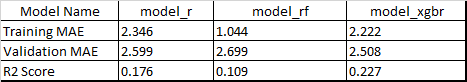


In [ ]:
def check_metrics(model):
  print(model)
  print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val,model.predict(X_val)))
  print('R2 score:', model.score(X_val,y_val))

model = [model_r,model_rf,model_xgbr]
for m in model:
  check_metrics(m)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)
Training MAE: 2.3461783438613137
Validation MAE: 2.599471728712658
R2 score: 0.17667821458870794
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Training MAE: 1.0440619375335929
Validation MAE: 2.695627388822867
R2 score: 0.11084881287510716
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rat

In [ ]:

#RandomizedSearchCV, for RandomForestRegressor, to search for the best parameters

clf = make_pipeline(OrdinalEncoder(),
                    SimpleImputer(), 
                    RandomForestRegressor(random_state=42, n_jobs = -1, max_samples=0.6))

param_grid = {'simpleimputer__strategy':['median','mean'], # 2 possible values
             'randomforestregressor__max_depth':range(5,60,5), # 11 possible values
             'randomforestregressor__n_estimators':range(25,200,25)} # 7 possible values

model_rfrs = RandomizedSearchCV(clf, 
                               param_distributions = param_grid,
                               n_iter = 50, # first time was 15, and try different values
                               cv = 5,
                               n_jobs = -1,
                               verbose = 10)
model_rfrs.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 24

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
# Best hyper parameters shown from cross validation research
model_rfrs.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

In [ ]:
#RandomizedSearchCV, for XGBRegressor, to search for the best parameters

clf_1 = make_pipeline(OrdinalEncoder(), 
                      SimpleImputer(), 
                      XGBRegressor(random_state=42, n_jobs = -1, max_samples=0.6))

param_grid = {'simpleimputer__strategy':['median','mean'], # 2 possible values
             'xgbregressor__max_depth':range(5,60,5), # 11 possible values
             'xgbregressor__n_estimators':range(25,200,25)} # 7 possible values

model_xgbrs = RandomizedSearchCV(clf_1, 
                               param_distributions = param_grid,
                               n_iter = 50, # first time was 15, and try different values
                               cv = 5,
                               n_jobs = -1,
                               verbose = 10)
model_xgbrs.fit(X,y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 61.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 87.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 89.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 99.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10

[18:52:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
# Best hyper parameters shown from cross validation research
model_xgbrs.best_params_

{'simpleimputer__strategy': 'median',
 'xgbregressor__max_depth': 5,
 'xgbregressor__n_estimators': 150}

# **7. Finalize Models**
Build Final Two Models, RandomForestRegressor and XGBRegressor, with the Best hyper parameters from Cross Validations, and compare with all 3 models, to Select the Best Model**

*   Build final model as model_rf_final, by plug-in the best hyper parameters identified from Cross Validation, RandomizedSearchCV, and check if improvements made on MAE, Mean Absolute Error, and R2 score
*   Build final model as model_xgbr_final, by plug-in the best pyer parameters identified from Cross Validation, RandomizedSearchCV, and check if improvements made on MAE, Mean Absolute Error, and R2 score.

*   Then, compare among model_rf_final, model_xgbr_final, and model_r, and choose the best MAE and R2 score result among the three, for the best model identified from calculations


In [ ]:
# Build model_rf_final, with pipeline, from cross validation, with best hyper parameters plug-in

model_rf_final = make_pipeline(OrdinalEncoder(),
                               SimpleImputer(strategy='median'), 
                               RandomForestRegressor(random_state=42, n_jobs = -1, max_samples=0.6, max_depth=10, n_estimators=75))



In [ ]:
# Build model_xgbr_final, with pipeline, from cross validation, with best hyper parameters plug-in

model_xgbr_final = make_pipeline(OrdinalEncoder(),
                                 SimpleImputer(strategy='median'), 
                                 XGBRegressor(random_state=42, n_jobs = -1, max_samples=0.6, max_depth=5, n_estimators=150))




In [ ]:
# Fit both models

model_rf_final.fit(X_train,y_train)
model_xgbr_final.fit(X_train,y_train)

[19:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booste...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=5, max_samples=0.6,
                              min_child_weight=1, missing=None,
                              n_estimators=150, n_jobs=-1, nthrea

In [ ]:
# Run MAE and R2 score results with hyper parameters in each model for comparison purpose

def check_metrics(model):
  print(model)
  print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val,model.predict(X_val)))
  print('R2 score:', model.score(X_val,y_val))

model = [model_r,model_rf_final,model_xgbr_final]
for m in model:
  check_metrics(m)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)
Training MAE: 2.3461783438613137
Validation MAE: 2.599471728712658
R2 score: 0.17667821458870794
Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=10,
                                       max_features='auto', max_leaf_nodes=None,
         

# *   **Comparing 3 models** 

*   Conculsion: model_xgbr_final is the best model with the lowest MAE and highest R2 score, and generalized well
*   With Cross Validation, RandomizedSearchCV, it certainly made improvements with hyper parameters calculated, and generalized well
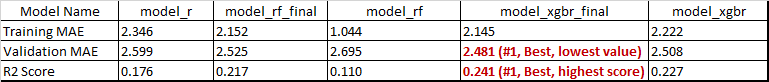




# **8. Feature Importance**
*   permutation importances for model interpretation

# Gini impurity as the following:



*   Feature Importance with the RandomForestRegressor model


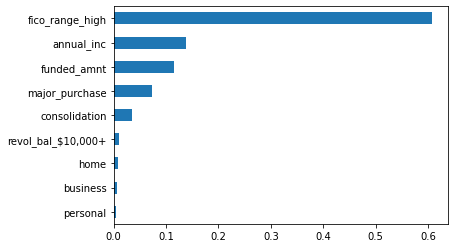

In [38]:
importances =  model_rf_final.named_steps['randomforestregressor'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')

*   Feature Importance with the XgbRegressor model

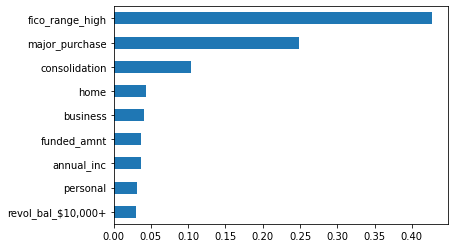

In [39]:
importances =  model_xgbr_final.named_steps['xgbregressor'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')

# **9. Communicate Results**
# Partial Dependence Plots
PDP of the most important two features, FICO score and major purchase, from the XgbRegressor model

In [ ]:
X_val.columns

Index(['business', 'consolidation', 'home', 'personal', 'major_purchase',
       'fico_range_high', 'funded_amnt', 'annual_inc', 'revol_bal_$10,000+'],
      dtype='object')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f74e0e7ad90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f74e05e2050>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


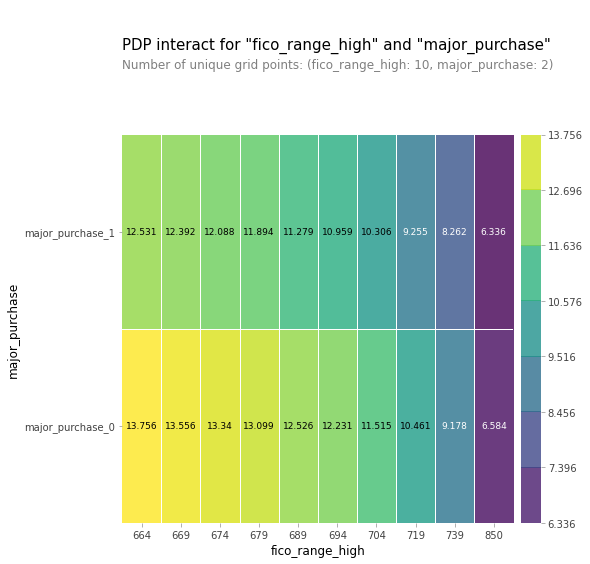

In [40]:
features = ['fico_range_high', 'major_purchase']
interact = pdp_interact(model_xgbr_final, dataset=X_val,
                        model_features = X_val.columns,
                        features = features)
pdp_interact_plot(interact,plot_type = 'grid',feature_names = features)

# This cell is notes to myself. Please disregard.
Both PDP and Shapley don't work with pipeline; not supported yet.
PDP is not possible to plot with more than 2 features.

# **Shapley Plots**

*   Show the influence of features in individual predictions


In [ ]:
# Shapley allows to visualize the prediction decision at the sample level. Take one sample as an example to view the decision
# The sample is row 108th
samp = X_val.head(108)

In [ ]:
# model_xgbr is, without pipeline, and model_xgbr_final (the best model) is, with pipeline.
# Because Shapley Plot does not support pipline, the best choice is using model_xgbr for the Shapley Plot
explainer = shap.TreeExplainer(model_xgbr)
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values=shap_values,
                features=samp)

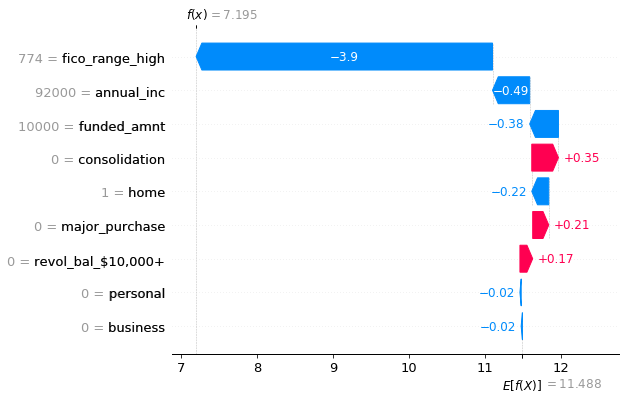

In [ ]:
explainer = shap.TreeExplainer(model_xgbr)
shap_values=explainer(X_val)
shap.plots.waterfall(shap_values[0])

# **Conclusion: by Utilizing Shapley Plots**

Show the influence of features in individual predictions

Adapting the highest rank of variable from both feature importance charts, the FICO score is the most important variable in interest rate prediction, and 2nd important variable is either major purchase or annual income.
In the Shapley plots, adapted from both feature importance charts, use the FICO score variable as X axis, either annual income or major purchase as Y axis, illustrated in the following Shapley charts: 
The baseline mean interest rate calculated is 11.488%.
X axis: FICO score at 734, Y axis: annual income at $122,000; the predicted interest rate is 10.76%, and the FICO score and income level could be different at predicting the interest rate as moving along the cursor in chart. 
X axis: FICO score at 729, Y axis: major purchase is affirmative; the predicted interest rate is 10.71%, and the FICO score and major purchase positive or negative, could be different at predicting the interest rate as moving along the cursor in chart. By reading the PDP plot, FICO score at 729, the predicting interest rate is between 8.75 to 11.989%, mean is 10.369%. Therefore, FICO score at 729 and major purchase positive, the predicted interest rate is between the range of 10.369 to 10.71%, by reading both PDP and one of the following Shapley charts.
In order to receive an interest rate offer lower than the baseline mean interest rate of 11.488%, among the Lending Club history. An applicant is better to have FICO score at least of 729, with annual income level equal or higher than $122,000, either major purchase positive or negative, the predicted interest rate range is between 10.369 to 10.76%, by reading the PDP and two following Shapley charts. 
Another just stepped-in new applicant, How will the interest rate predicted? 
Search the whole dataset, identify if a historical applicant has the exact or very similar variables as the new applicant. Then, use the historical applicant variables for the new applicant; and insert the variables in the test data frame of the built models; and then identify the certain row of observation for the new applicant in the test data frame, to exercise the interest rate prediction drill just did.
If the new applicant does not have similar variables in history. Insert new applicant variables in the test data frame of the built models; and then identify the certain row of observation for the new applicant in the test data frame, to exercise the interest rate prediction drill just did.

Yes, the interest rate really predicted, as long as the continual efforts made on model improvements, the predicted interest rate range could be narrower.

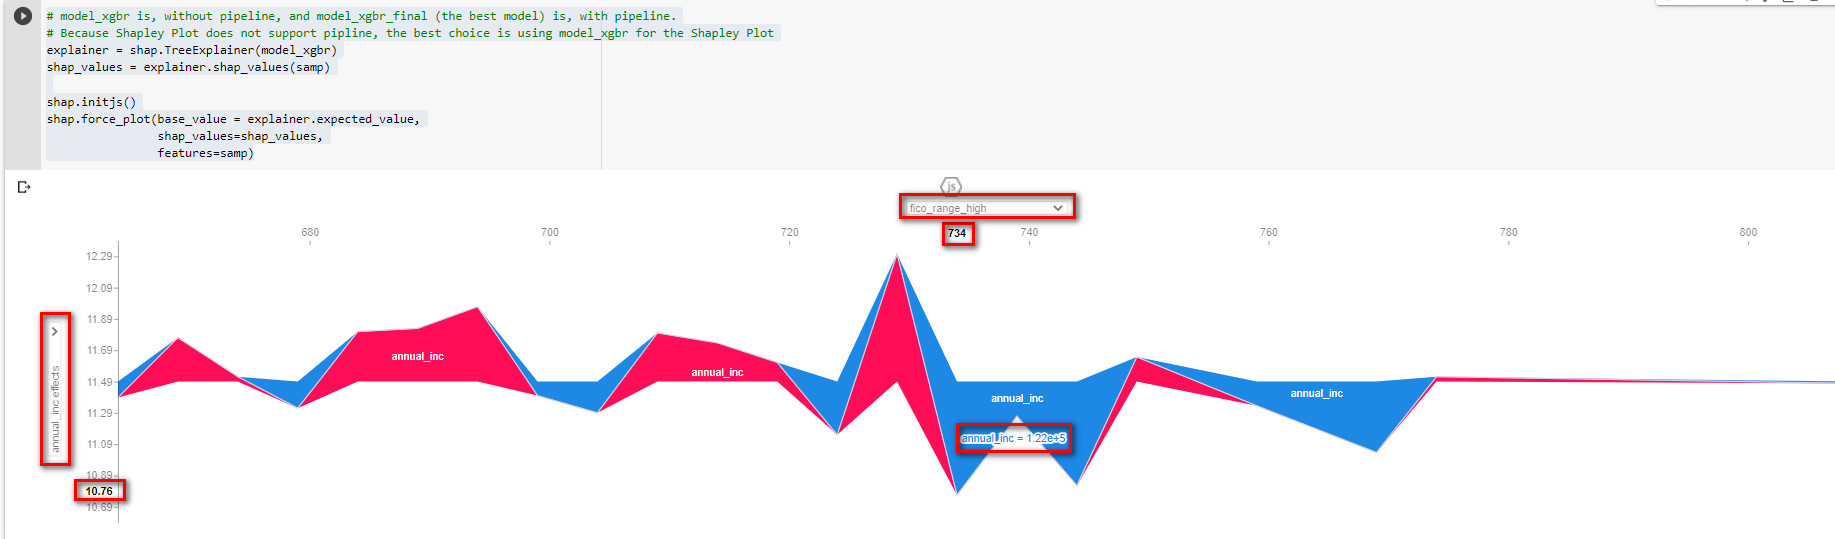

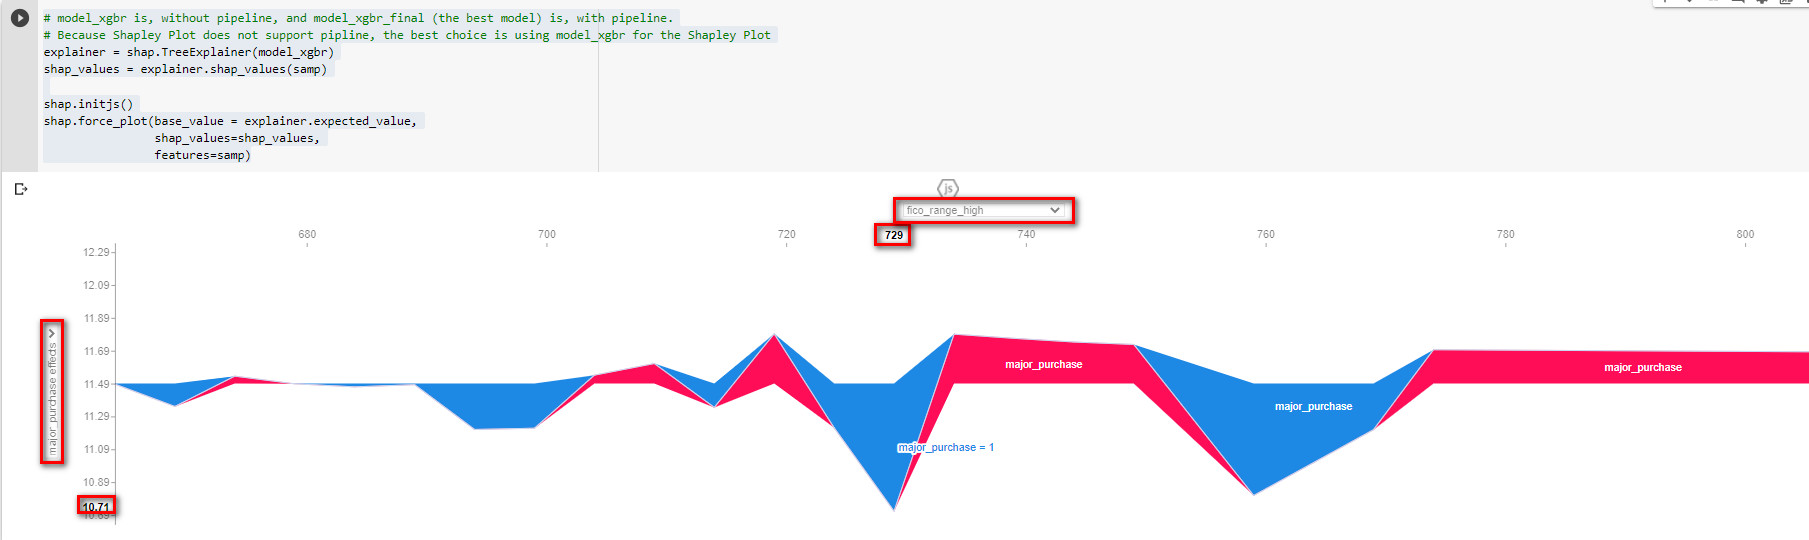

#This cell is notes to myself. Please disregard.
For Shapley plot -- If I have X_train, X_val, and X_test, should I use X_val or X_test to make the plot? Choose one sample from the X_val, correct?, not from X_test

You could do your X_val or X_test.. doesn’t matter. I would say use X_test because onc eyou find optimal hyperparameters, you would retrain your model using X_train and X_val put together.

# **This cell is notes to myself, not part of the project. Please disregard.**
The link given below has specifics regarding the rubric and data sets that you are not allowed to choose. https://lambdaschool.instructure.com/courses/1469/wiki Make sure your datatset has at least 10 useful features. The number of samples could be anywhere between 500 and half a million. You could choose to build regression or classification models for build week. It is totally your choice. For you to get an approval, make sure you have the following details.

How many samples do you have?
How many features do you have?
Is there scope for feature engineering?
How is your data distributed?
If it is a regression problem, plot your target variable and see if the distribution is skewed or it’s resembles a normal curve.
If it is a classification problem, look at how many samples you have for each class.
Once you get these specifics, I will be able to approve your datasets. Let me know if you have any questions!!

check distribution if it is a classification problem, just look at how many samples are there for each class

# **END**